# Purpose
- To explore the t-test and it's assumptions

# Background

To perform null-hypothesis significant testing with the t-test we need:
- A population parameter to test: $\mu$
- An $H_0$: $\mu = something$
- A test statistic: $t$
- A null distribution for the test statistic: $t \sim t_{df} \sim t_{n-1}$, where $n$ is the sample size

The t-test, then, uses the $t$ statistic. This $t$ is derived from:
- starting from $\bar{X}$, the sample mean, as statistic
- since via the central limit theorem, $\bar{X} \sim AN(\mu, \frac{\sigma^2}{n})$, we can re-arrange to get a statistic that is distributed as a Normal with 0 mean and 1 variance: $\frac{\bar{X} - \mu}{\frac{\sigma}{\sqrt{n}}} \sim AN(0,1)$
- This would be a Z statistic, but there's an issue: most of the times we can't know the population variance $\sigma^2$ so we replace it with the sample variance $S^2$ which is: $S^2 = \frac{\sum\limits_{i=1}^{N}(X_i - \bar{X})^2}{n-1}$
- Now, to this statistic $\frac{\bar{X} - \mu}{\frac{S}{\sqrt{n}}} \sim AN(0,1)$ we call $t$ and it's parametrized with the degrees of freedom $df$
- These degrees of freedom depend only on the sample size $n$ and are equal to $df = n-1$ instead of just $n$ because for the $t$ statistic we must "use" one $df$ to calculate the sample mean $\bar{X}$ in order to estimate $S$ (basically $t$ is actually a function of 2 random variables, $S$ and $\bar{X}$)
- The additional randomness given by the 2 random variables makes $t$ follow a similar distribution as $Z$ but with longer tails
- We call this distribution, the $t$ distribution and it's the null distribution used for the t-test

# Import packages

In [1]:
using Pkg
Pkg.status()

Status `/mnt/weird_vol/projects/playaround/Notebooks-Research/Statistics/Project.toml`
  [a93c6f00] DataFrames v1.6.1
  [31c24e10] Distributions v0.25.108
  [09f84164] HypothesisTests v0.11.0
  [91a5bcdd] Plots v1.40.4
  [f3b207a7] StatsPlots v0.15.7


In [301]:
using Random
using Distributions
using Plots.PlotMeasures
using StatsPlots
using DataFrames
using Printf
using HypothesisTests

# t-test

In [3]:
Random.seed!(1)

μ0 = 50
sample_size = 20

model = Normal(45, 10)
x = rand(model, sample_size)

display(mean(x))

43.71734560485239

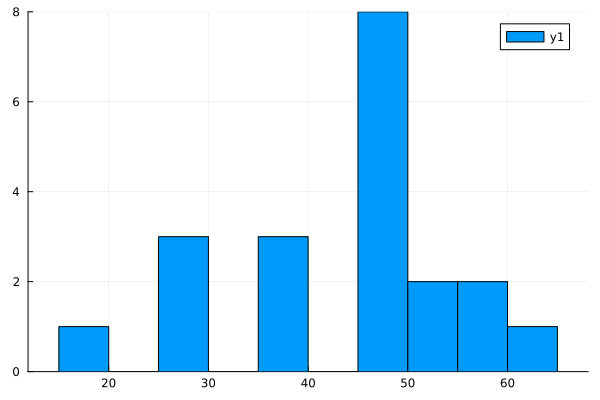

In [4]:
histogram(x, bins=10)

# By package

In [20]:
display("t-test via a package")
ttest = OneSampleTTest(x, μ0)
display(ttest)

"t-test via a package"

One sample t-test
-----------------
Population details:
    parameter of interest:   Mean
    value under h_0:         50
    point estimate:          43.7173
    95% confidence interval: (38.48, 48.96)

Test summary:
    outcome with 95% confidence: reject h_0
    two-sided p-value:           0.0213

Details:
    number of observations:   20
    t-statistic:              -2.5097130000252785
    degrees of freedom:       19
    empirical standard error: 2.5033357977921495


# By Hand

## Calculate the t-statistic

In [5]:
n = sample_size
X̄ = sum(x) / n
S² = (sum((x .- X̄).^2)) / (n - 1)
S = √S²

t = (X̄ - μ0) / (S / √n)

-2.5097130000252785

In [6]:
df = n-1

model = TDist(df)
pval_2sided = (1-cdf(model, -t) + cdf(model, t))  # The area under the t-distribution that is more extreme than t, given that we didn't know the directionality of t at H0 (2-sided test)

0.021299520091725414

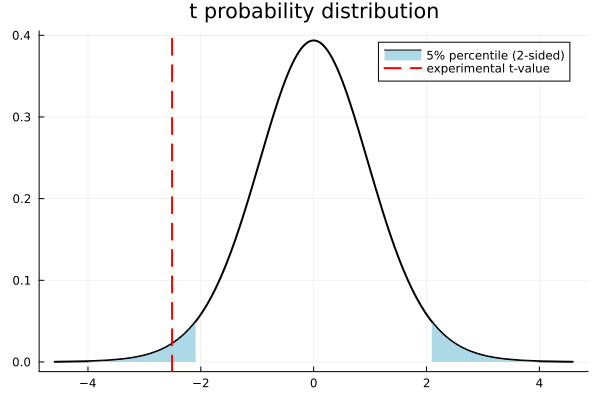

In [93]:
plot(model, lc=:black, lw=2, title="t probability distribution", primary=false)

α = 0.05  # the value at which we consider significance
q_α = quantile(model, α/2)  # this is the value of t at which the probability is less than or equal to the α. We divide α by 2 to perform a 2-sided test 

x1 = range(-4, q_α, length=50) 
x2 = range(-q_α, 4, length=50)

y1 = pdf.(model, x1)
y2 = pdf.(model, x2)

plot!(x1, y1, fillrange=0, fc=:blues, lc=:black, primary=false)
plot!(x2, y2, fillrange=0, fc=:blues, lc=:black, label="5% percentile (2-sided)")

vline!([t], lw=2, ls=:dash, lc=:red, label="experimental t-value")

In [ ]:
Random.seed!(1)

In [324]:
"""
Compute a one-sample t-test and plot the computed t statistic in the t distribution

μ0 - the hypothesis for the mean
μ  - the real population mean
σ  - the real population variance
n  - the sample size
α  - the value at which we consider statistical significance
"""
function calculate_and_plot_t(μ0::Real, μ::Real, σ::Real, n::Real; α::Real=0.05, n_simulations::Real=100)

    pval_2sided_list = []
    t_list = []
    for i in range(0, n_simulations)
        ######## Calculate statistics ########
        model = Normal(μ, σ)
        x = rand(model, n)

        X̄ = sum(x) / n
        S² = (sum((x .- X̄) .^ 2)) / (n - 1)
        S = √S²

        t = (X̄ - μ0) / (S / √n)

        append!(t_list, t)

        df = n - 1
        model = TDist(df)
        pval_2sided = (1 - cdf(model, -t) + cdf(model, t))  # The area under the t-distribution that is more extreme than t, given that we didn't know the directionality of t at H0 (2-sided test)
        append!(pval_2sided_list, pval_2sided)
    end


    ######## Plot the t values ########
    plt_t = histogram(
        t_list,
        bins=Int(n_simulations / 2),
        normalize=:pdf,
        color=:orange,
        lw=0,
        label="calculated t values"
    )

    plot!(
        model,
        lc=:black,
        lw=2,
        title="t probability distribution",
        primary=false,
        grid=false
    )

    q_α = quantile(model, α / 2)  # this is the value of t at which the probability is less than or equal to the α. We divide α by 2 to perform a 2-sided test 

    x1 = range(-4, q_α, length=50)
    x2 = range(-q_α, 4, length=50)

    y1 = pdf.(model, x1)
    y2 = pdf.(model, x2)

    plot!(x1, y1, fillrange=0, fc=:blues, lc=:black, primary=false)
    plot!(x2, y2, fillrange=0, fc=:blues, lc=:black, label="5% percentile (2-sided)")

    # vline!([t], lw=2, ls=:dash, lc=:red, label="experimental t-value")

    ######## Plot the t values ########
    plt_pval = density(
        pval_2sided_list,
        trim=true,
        lc=:black,
        lw=2,
        xlims=(0, maximum([pval_2sided_list; [α]])),
        yaxis=false,
        grid=false,
        label="p-values",
        title="p-value distribution",
    )

    vline!(
        [median(pval_2sided_list)],
        lw=3,
        ls=:dash,
        lc=:black,
        label="percentile 50 of calculated p-values"
    )

    vline!(
        [α],
        lw=3,
        ls=:dash,
        lc=:blues,
        label="α"
    )

    ######## Display stuff ########
    plot(
        plt_t,
        plt_pval,
        layout=(1, 2),
        size=(1000, 400)
    )

end

calculate_and_plot_t

# Explore differences in sample size

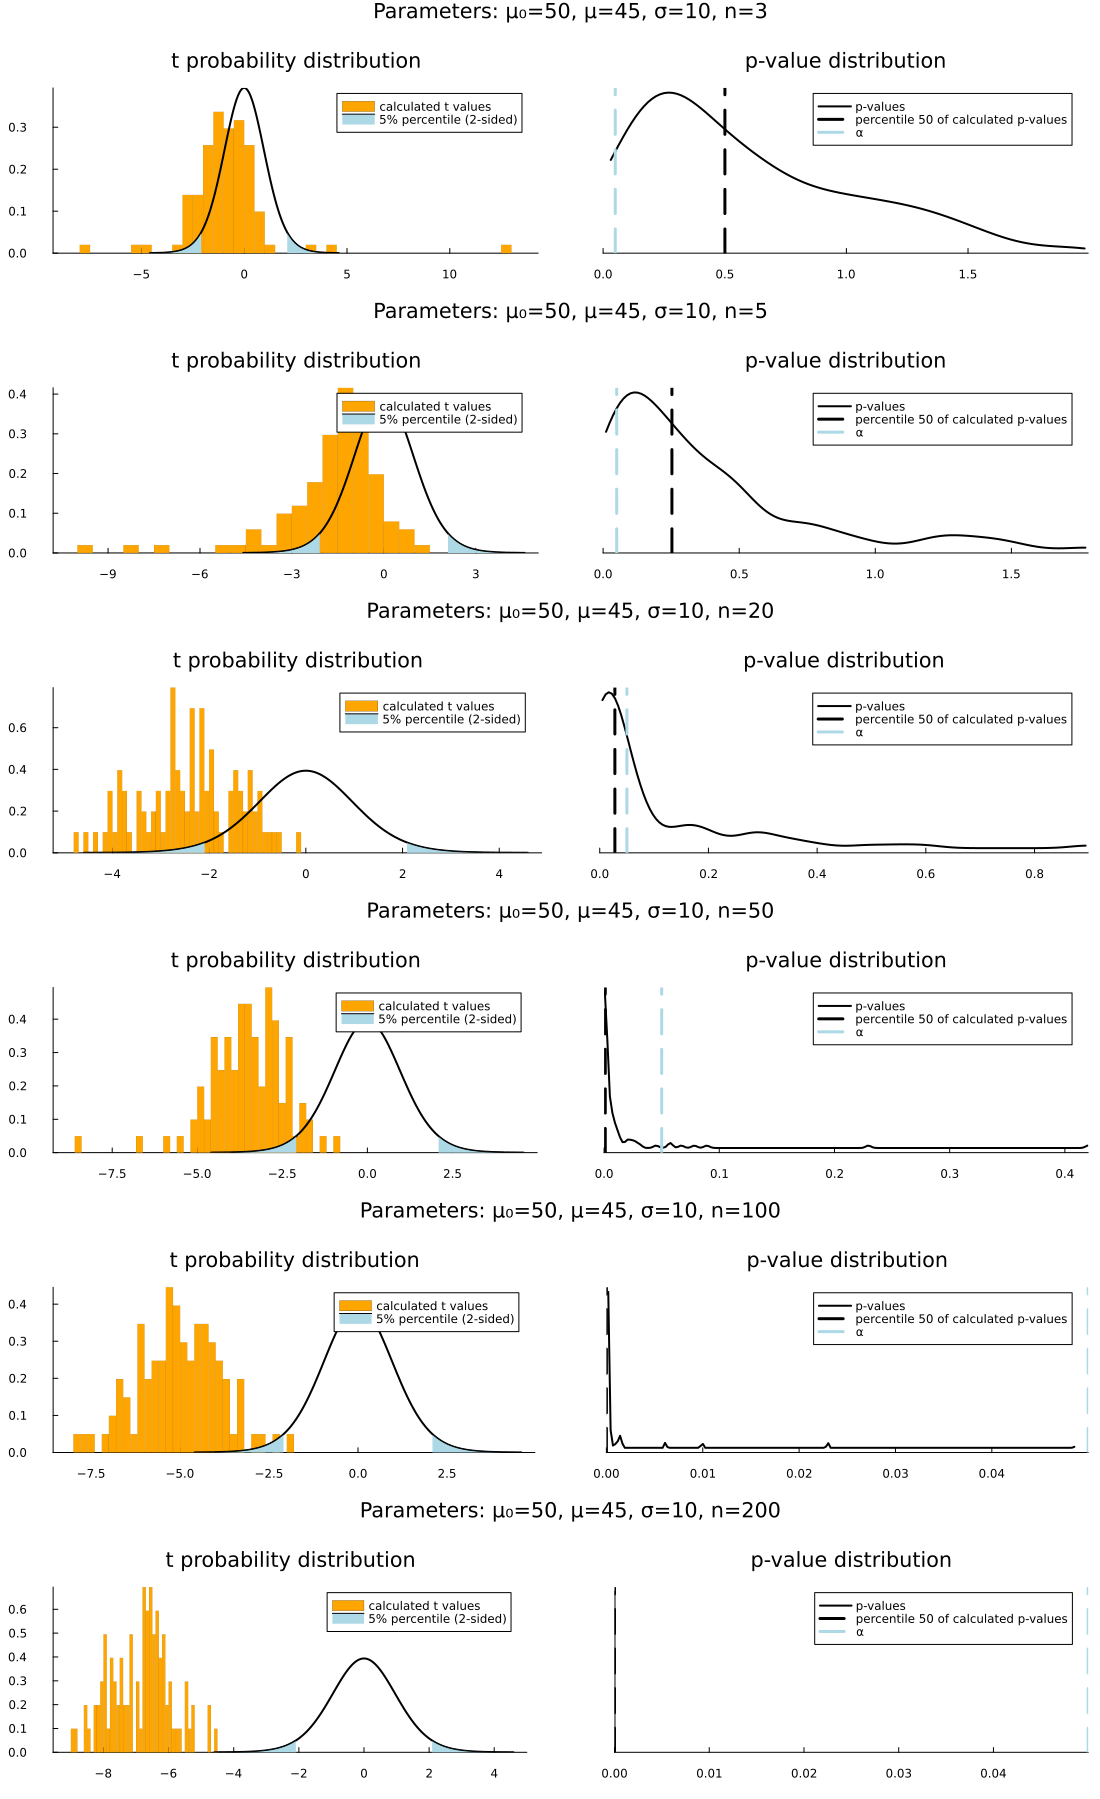

In [329]:
# Change these variables
μ0 = 50  # the hypothesis for the mean
μ = 45  # the real population mean
σ = 10  # the real population variance
n_list = [3, 5, 20, 50, 100, 200]  # the sample size

plt_array = []
for n in n_list
    title = plot(title = @sprintf("Parameters: μ₀=%s, μ=%s, σ=%s, n=%s", μ0, μ, σ, n), grid = false, showaxis = false, bottom_margin = -50Plots.px)
    plt = plot(
        title,
        calculate_and_plot_t(μ0, μ, σ, n),
        layout=@layout([a{0.10h}; grid(1,1)])
    )
    push!(plt_array, plt)
end

plot(
    plt_array...,
    layout=(length(n_list), 1),
    size=(1100, 300*length(n_list)),
    bg="white",
    left_margin=5mm
)

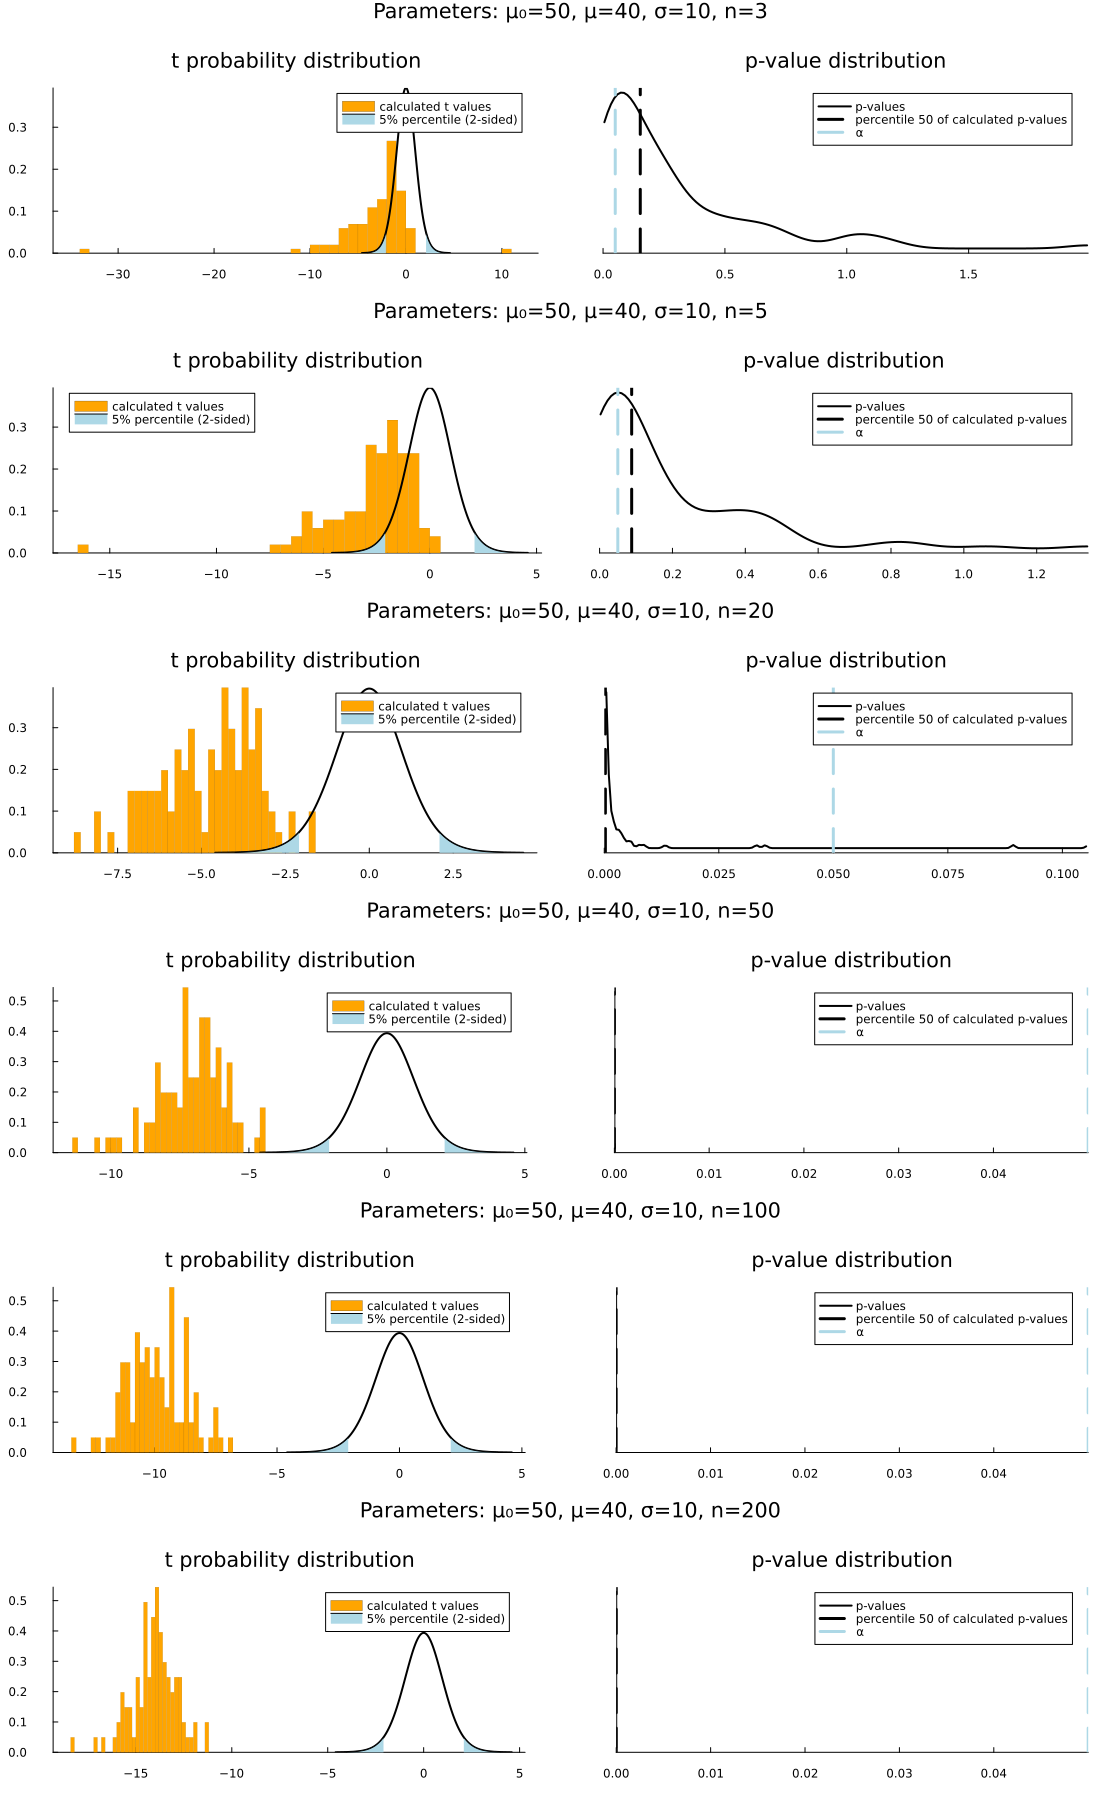

In [330]:
# Change these variables
μ0 = 50  # the hypothesis for the mean
μ = 40  # the real population mean
σ = 10  # the real population variance
n_list = [3, 5, 20, 50, 100, 200]  # the sample size

plt_array = []
for n in n_list
    title = plot(title = @sprintf("Parameters: μ₀=%s, μ=%s, σ=%s, n=%s", μ0, μ, σ, n), grid = false, showaxis = false, bottom_margin = -50Plots.px)
    plt = plot(
        title,
        calculate_and_plot_t(μ0, μ, σ, n),
        layout=@layout([a{0.10h}; grid(1,1)])
    )
    push!(plt_array, plt)
end

plot(
    plt_array...,
    layout=(length(n_list), 1),
    size=(1100, 300*length(n_list)),
    bg="white",
    left_margin=5mm
)

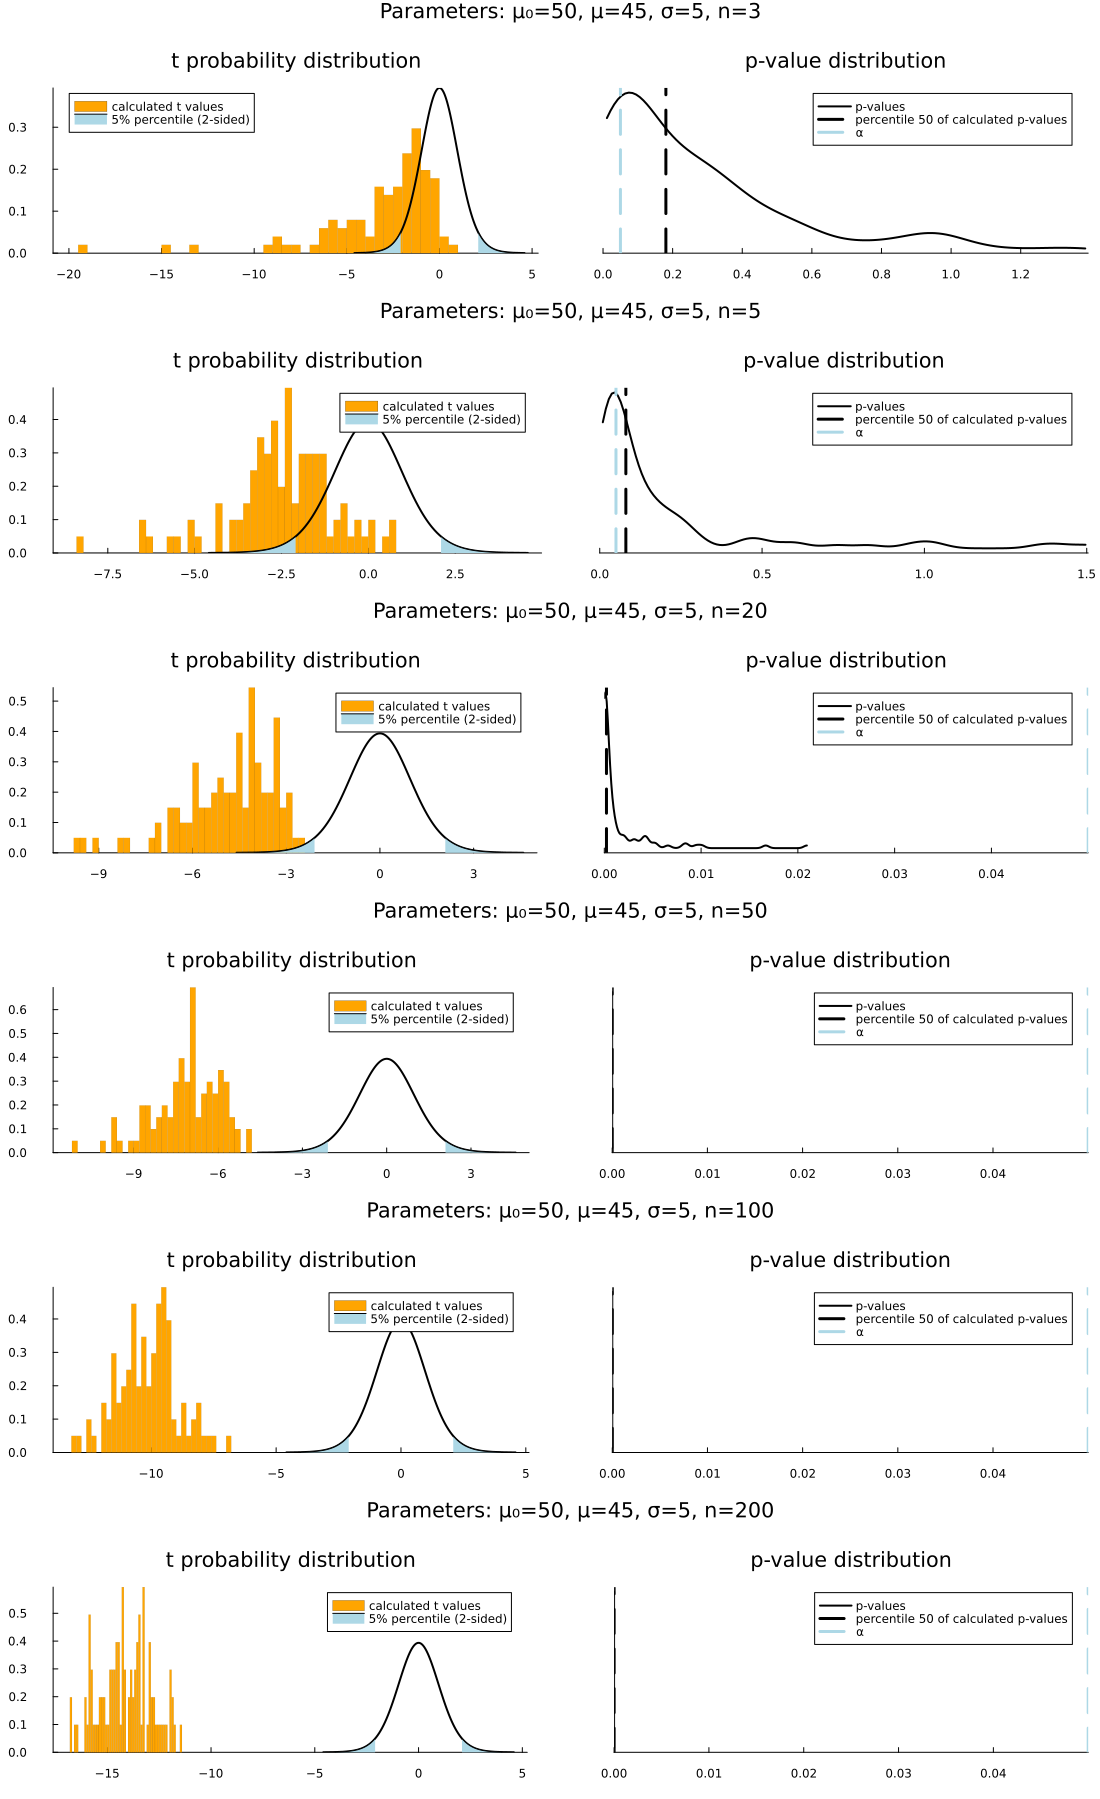

In [331]:
# Change these variables
μ0 = 50  # the hypothesis for the mean
μ = 45  # the real population mean
σ = 5  # the real population variance
n_list = [3, 5, 20, 50, 100, 200]  # the sample size

plt_array = []
for n in n_list
    title = plot(title = @sprintf("Parameters: μ₀=%s, μ=%s, σ=%s, n=%s", μ0, μ, σ, n), grid = false, showaxis = false, bottom_margin = -50Plots.px)
    plt = plot(
        title,
        calculate_and_plot_t(μ0, μ, σ, n),
        layout=@layout([a{0.10h}; grid(1,1)])
    )
    push!(plt_array, plt)
end

plot(
    plt_array...,
    layout=(length(n_list), 1),
    size=(1100, 300*length(n_list)),
    bg="white",
    left_margin=5mm
)

# Explore differences in fold-changes

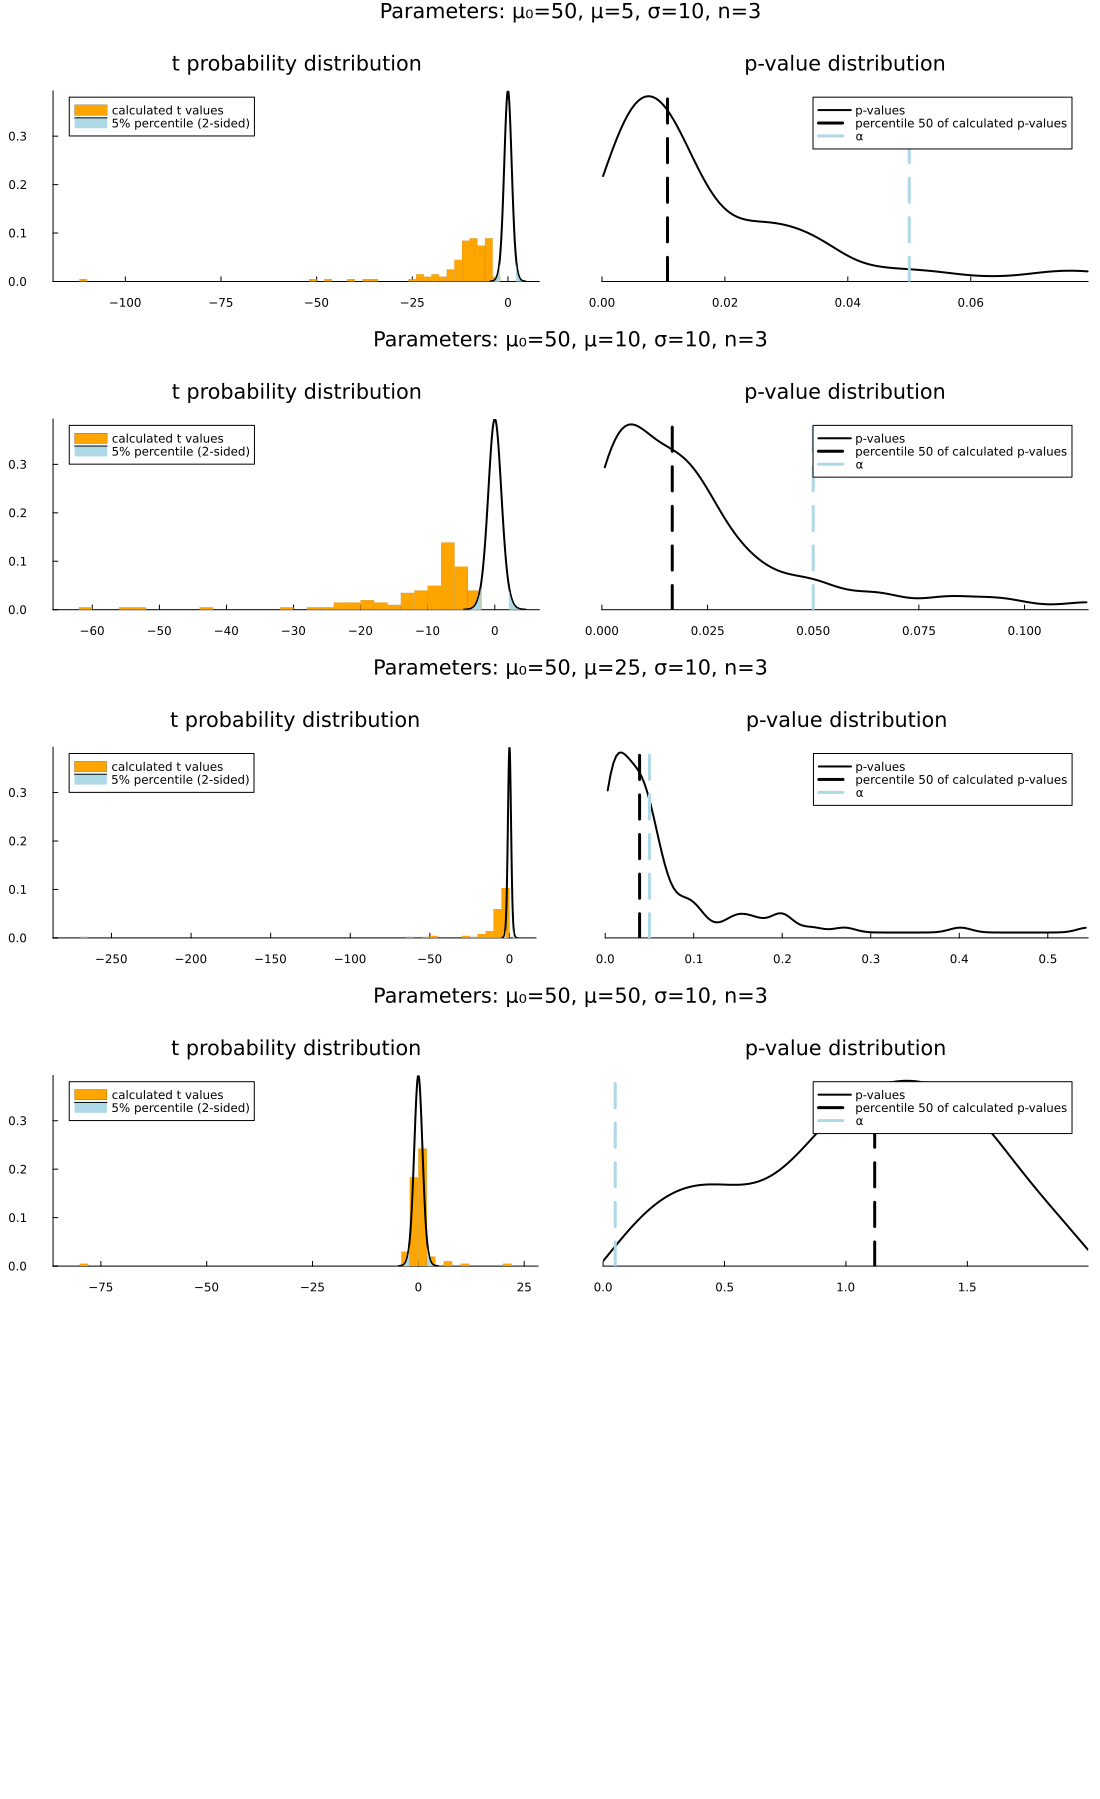

In [333]:
# Change these variables
μ0 = 50  # the hypothesis for the mean
μ_list = [5, 10, 25, 50]   # the real population mean
σ = 10  # the real population variance
n = 3  # the sample size

plt_array = []
for μ in μ_list
    title = plot(title = @sprintf("Parameters: μ₀=%s, μ=%s, σ=%s, n=%s", μ0, μ, σ, n), grid = false, showaxis = false, bottom_margin = -50Plots.px)
    plt = plot(
        title,
        calculate_and_plot_t(μ0, μ, σ, n),
        layout=@layout([a{0.10h}; grid(1,1)])
    )
    push!(plt_array, plt)
end

plot(
    plt_array...,
    layout=(length(n_list), 1),
    size=(1100, 300*length(n_list)),
    bg="white",
    left_margin=5mm
)